# **Install dependencies**

In [1]:
# %pip install POT

# **Unconditional Flow Model**

## **Define synthetic data**

Libraries imported successfully.


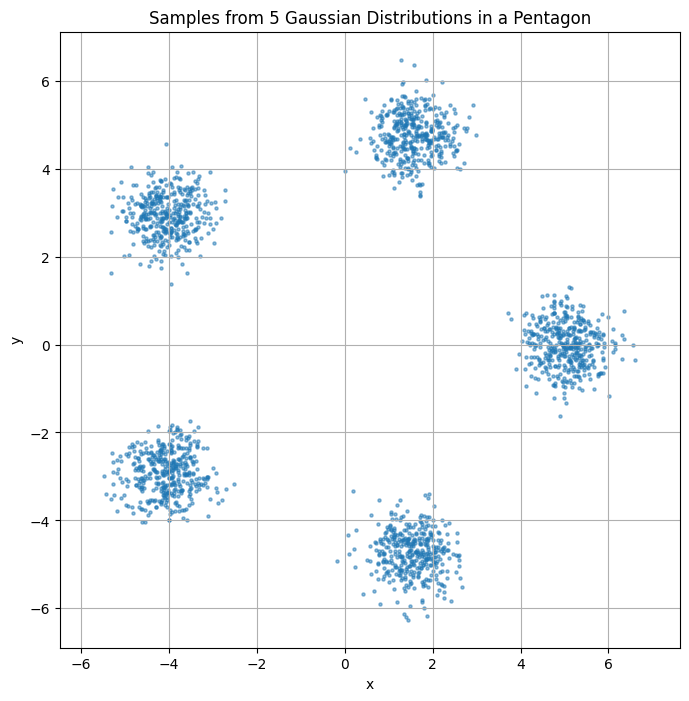

Functions 'sample_gaussian' and 'sample_n_gaussians' defined.


In [ ]:
from typing import Optional
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

print("Libraries imported successfully.")

def sample_gaussian(num_samples):
    """Generates samples from a 2D standard Gaussian distribution."""
    # Mean 0, standard deviation 1 for both dimensions
    samples = torch.randn(num_samples, 2)
    return samples

def sample_n_gaussians(num_samples, num_gaussians=5, rotation: Optional[float]=0):
    """Generates samples from N distinct 2D Gaussian distributions arranged in a pentagon."""
    # Define means for N Gaussians arranged in a pentagon
    # Radius of the pentagon
    R = 5.0
    # Angles for the vertices of a regular pentagon
    # Convert np.pi to a standard float to avoid TypeError with torch.linspace
    angles = torch.linspace(0, float(2 * np.pi), num_gaussians + 1)[:-1]

    means = []
    for angle in angles:
        x = R * torch.cos(angle + rotation)
        y = R * torch.sin(angle + rotation)
        means.append(torch.tensor([x, y]))

    std_dev = 0.5 # Common standard deviation for all 5 Gaussians

    # Generate samples
    samples = torch.empty(num_samples, 2)
    for i in range(num_samples):
        # Randomly choose one of the N Gaussians
        chosen_mean_idx = torch.randint(0, len(means), (1,)).item()
        chosen_mean = means[chosen_mean_idx]

        # Sample from the chosen Gaussian
        samples[i] = chosen_mean + torch.randn(2) * std_dev

    return samples


def sample_moons(num_samples, noise=0.1):
    """Generates samples from the two-moons dataset."""
    data, _ = make_moons(n_samples=num_samples, noise=noise)
    return torch.tensor(data, dtype=torch.float32)

# --- Sample and plot ---
samples = sample_n_gaussians(2000)

plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.title("Samples from 5 Gaussian Distributions in a Pentagon")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()


print("Functions 'sample_gaussian' and 'sample_n_gaussians' defined.")

## **Velocity Field Model**

In [3]:
class VelocityField(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[64, 64], output_dim=2):
        super(VelocityField, self).__init__()
        layers = []
        # First layer combines input_dim (x and t)
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Output layer (no activation function)
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        # x: (batch_size, 2)
        # t: (batch_size, 1) or (batch_size,)

        # Ensure t has the correct shape for concatenation: (batch_size, 1)
        if t.dim() == 1:
            t = t.unsqueeze(1) # Add a dimension for concatenation

        # Concatenate x and t along the feature dimension
        input_tensor = torch.cat([x, t], dim=1)

        return self.net(input_tensor)

print("Neural network for velocity field ('VelocityField' class) defined.")

Neural network for velocity field ('VelocityField' class) defined.


## **Conditional Flow Matching Loss**

In [4]:
import torch.nn.functional as F

def conditional_flow_matching_loss(velocity_field_model, x0, x1, device):
    """Calculates the Conditional Flow Matching loss."""
    batch_size = x0.shape[0]

    # 2. Generate random time steps t uniformly between 0 and 1
    t = torch.rand(batch_size, 1, device=device) # (batch_size, 1)

    # 3. Calculate xt, the interpolated point along the straight path
    xt = t * x1 + (1 - t) * x0

    # 4. Calculate ut, the true velocity vector along the straight path
    ut = x1 - x0

    # 5. Pass xt and t to the velocity_field_model to get the predicted velocity
    vt = velocity_field_model(xt, t)

    # 6. Compute the mean squared error (MSE) between ut and vt
    loss = F.mse_loss(vt, ut)

    return loss

## **OT-CFM Training**

In [5]:
from scipy.optimize import linear_sum_assignment

def compute_ot_matching(x0, x1):
    """
    Pairs points from x0 to x1 to minimize total squared distance.
    Returns sorted_x0, sorted_x1 that correspond to straight paths.
    """
    # 1. Compute Cost Matrix (Squared Euclidean Distance)
    # Dist matrix shape: (Batch, Batch)
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2<x, y>
    with torch.no_grad():
        x0_sq = torch.sum(x0**2, dim=1, keepdim=True)
        x1_sq = torch.sum(x1**2, dim=1, keepdim=True)

        # dist[i, j] is distance between noise[i] and data[j]
        dist = x0_sq + x1_sq.t() - 2 * torch.mm(x0, x1.t())

        # Move to CPU for SciPy (batch size 512 is fast enough)
        cost_matrix = dist.cpu().numpy()

        # 2. Solve Assignment Problem (Hungarian Algorithm)
        # row_ind usually just [0, 1, ... N], col_ind is the permutation
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # 3. Reorder the batches
        # We can just reorder x1 to match x0's order
        x1_sorted = x1[col_ind]

        return x0, x1_sorted

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Instantiate the VelocityField model and move it to the selected device
model = VelocityField(input_dim=3, hidden_dims=[128, 128, 128], output_dim=2).to(device)

# 3. Define the optimizer and learning rate
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 4. Set training parameters
num_epochs = 4000 # Increased epochs for better convergence
batch_size = 256
num_samples = 2048 # Total samples per epoch

# 5. Initialize an empty list to store training loss values
training_losses = []

print("Starting training with Optimal Transport pairing...")
for epoch in range(num_epochs):
    # a. Generate num_samples from sample_gaussian (x0) and sample_5_gaussians (x1)
    x0 = sample_gaussian(num_samples).to(device)
    x1 = sample_n_gaussians(num_samples).to(device)

    # Create a DataLoader for batching
    dataset = torch.utils.data.TensorDataset(x0, x1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    epoch_losses = []
    for i, (x0_batch, x1_batch) in enumerate(dataloader):
        x0_np = x0_batch.cpu().numpy()
        x1_np = x1_batch.cpu().numpy()

        x0_batch_ot, x1_batch_ot = compute_ot_matching(torch.tensor(x0_np, device=device), torch.tensor(x1_np, device=device))
        
        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        loss = conditional_flow_matching_loss(model, x0_batch_ot, x1_batch_ot, device)

        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())

    avg_epoch_loss = np.mean(epoch_losses)
    training_losses.append(avg_epoch_loss)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

print("Training complete with OT pairing.")

Using device: cuda
Starting training with Optimal Transport pairing...
Epoch 1/4000, Loss: 6.3617
Epoch 100/4000, Loss: 0.1225
Epoch 200/4000, Loss: 0.1034
Epoch 300/4000, Loss: 0.1043
Epoch 400/4000, Loss: 0.1085
Epoch 500/4000, Loss: 0.0999
Epoch 600/4000, Loss: 0.1168
Epoch 700/4000, Loss: 0.0810
Epoch 800/4000, Loss: 0.0947
Epoch 900/4000, Loss: 0.0843
Epoch 1000/4000, Loss: 0.0890
Epoch 1100/4000, Loss: 0.0952
Epoch 1200/4000, Loss: 0.0811
Epoch 1300/4000, Loss: 0.1094
Epoch 1400/4000, Loss: 0.0916
Epoch 1500/4000, Loss: 0.0870
Epoch 1600/4000, Loss: 0.0771
Epoch 1700/4000, Loss: 0.0860
Epoch 1800/4000, Loss: 0.0871
Epoch 1900/4000, Loss: 0.0663
Epoch 2000/4000, Loss: 0.0828
Epoch 2100/4000, Loss: 0.1129
Epoch 2200/4000, Loss: 0.0770
Epoch 2300/4000, Loss: 0.0770
Epoch 2400/4000, Loss: 0.0797
Epoch 2500/4000, Loss: 0.0795
Epoch 2600/4000, Loss: 0.1018
Epoch 2700/4000, Loss: 0.1112
Epoch 2800/4000, Loss: 0.1075
Epoch 2900/4000, Loss: 0.1003
Epoch 3000/4000, Loss: 0.0715
Epoch 3100/

### Visualize loss

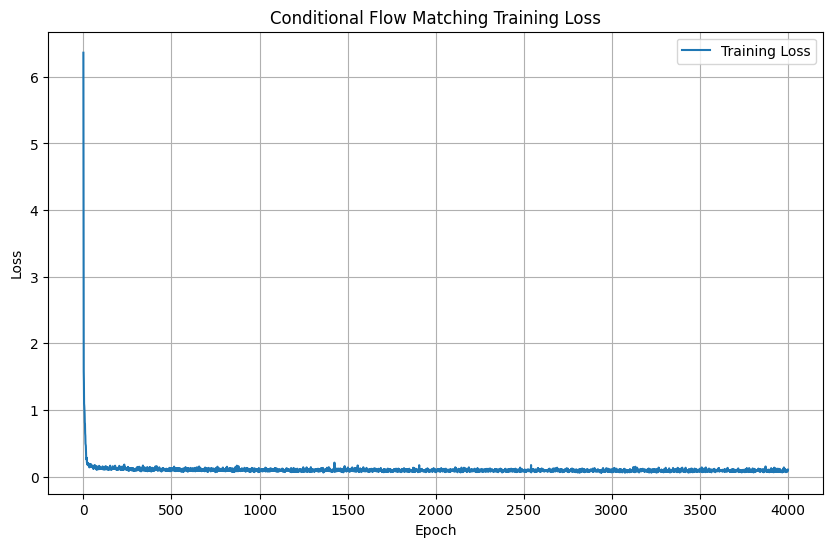

Training loss plot generated successfully.


In [7]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional Flow Matching Training Loss')
plt.grid(True)
plt.legend()
plt.show()

print("Training loss plot generated successfully.")

## **Visualize trajectory paths**

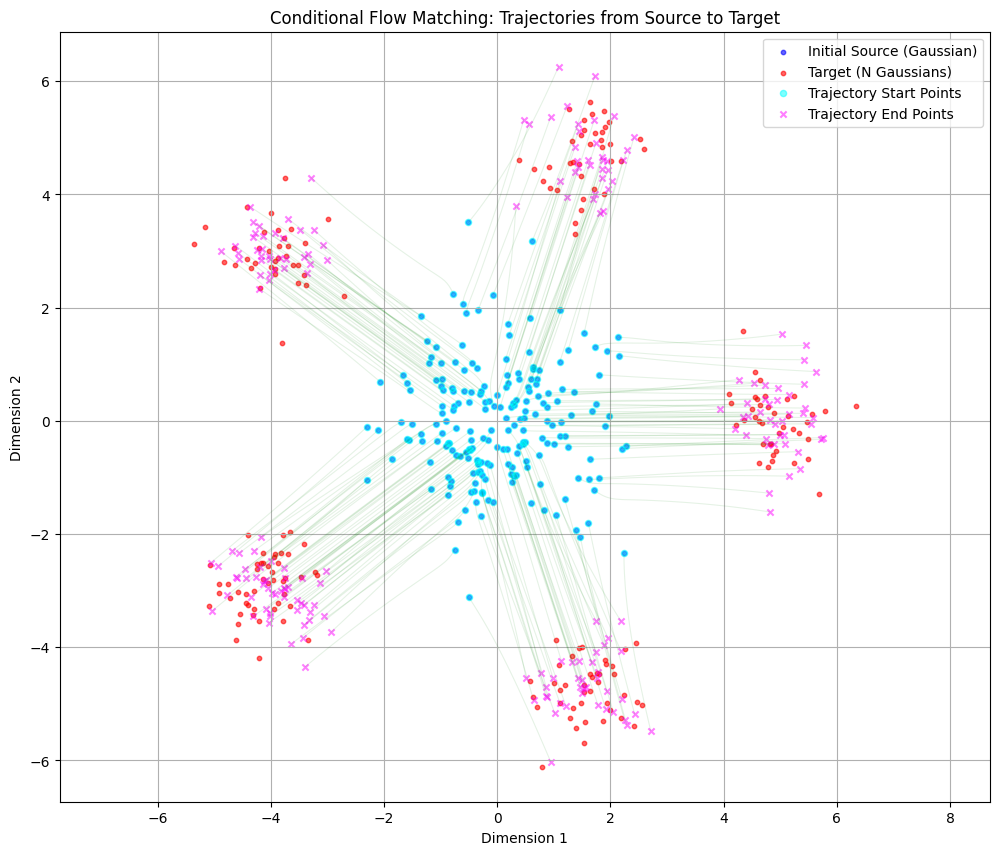

Trajectory visualization generated successfully.


In [8]:
# Set the model to evaluation mode
model.eval()

# Number of trajectories to visualize
num_trajectory_samples = 200

# Sample initial points from the source Gaussian distribution
x0_eval = sample_gaussian(num_trajectory_samples).to(device)

# Sample target points from the 5 Gaussians distribution (for context)
x1_eval_context = sample_n_gaussians(num_trajectory_samples).to(device)

# Simulate trajectories
t_steps = 50  # Number of time steps for trajectory simulation
delta_t = 1.0 / t_steps

trajectories = torch.zeros(t_steps + 1, num_trajectory_samples, 2).to(device)
trajectories[0] = x0_eval

current_x = x0_eval
with torch.no_grad(): # No need to compute gradients during simulation
    for i in range(t_steps):
        t_val = torch.full((num_trajectory_samples, 1), i * delta_t, device=device)
        velocity = model(current_x, t_val)
        current_x = current_x + velocity * delta_t
        trajectories[i+1] = current_x

# Move trajectories to CPU for plotting
trajectories_cpu = trajectories.cpu().numpy()
x0_eval_cpu = x0_eval.cpu().numpy()
x1_eval_context_cpu = x1_eval_context.cpu().numpy()

# Plotting
plt.figure(figsize=(12, 10))

# Plot initial source distribution
plt.scatter(x0_eval_cpu[:, 0], x0_eval_cpu[:, 1], color='blue', alpha=0.6, label='Initial Source (Gaussian)', s=10)

# Plot final target distribution
plt.scatter(x1_eval_context_cpu[:, 0], x1_eval_context_cpu[:, 1], color='red', alpha=0.6, label='Target (N Gaussians)', s=10)

# Plot trajectories
for i in range(num_trajectory_samples):
    plt.plot(trajectories_cpu[:, i, 0], trajectories_cpu[:, i, 1], color='green', alpha=0.1, linewidth=0.8)

# Plot start and end points of some trajectories more distinctly
plt.scatter(trajectories_cpu[0, :, 0], trajectories_cpu[0, :, 1], color='cyan', marker='o', s=20, alpha=0.5, label='Trajectory Start Points')
plt.scatter(trajectories_cpu[-1, :, 0], trajectories_cpu[-1, :, 1], color='magenta', marker='x', s=20, alpha=0.5, label='Trajectory End Points')

plt.title('Conditional Flow Matching: Trajectories from Source to Target')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.axis('equal') # Keep aspect ratio equal
plt.show()

print("Trajectory visualization generated successfully.")

# **Fewshot Guidance**

## Guided dataset

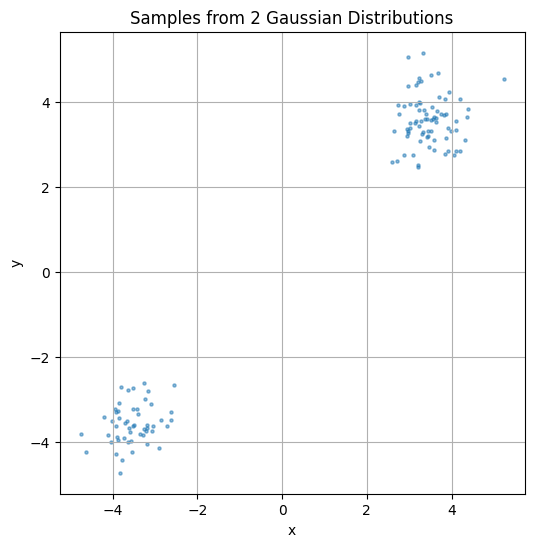

In [9]:
guided_data = sample_n_gaussians(128, num_gaussians=2, rotation=1*np.pi/4)

plt.figure(figsize=(6, 6))
plt.scatter(guided_data[:, 0], guided_data[:, 1], s=5, alpha=0.5)
plt.title("Samples from 2 Gaussian Distributions")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

In [10]:
# Data info
print("Number of samples:", len(guided_data))
print("Sample Shape:", guided_data.shape)

Number of samples: 128
Sample Shape: torch.Size([128, 2])


## Guidance Loss

In [14]:
import torch.nn.functional as F

def guidance_loss(guided_model, velocity_model, x0, x1, device):
    """Calculates the Guidance loss."""
    batch_size = x0.shape[0]

    t = torch.rand(batch_size, 1, device=device) # (batch_size, 1)

    xt = t * x1 + (1 - t) * x0

    ut = x1 - x0

    vt = guided_model(xt, t) + velocity_model(xt, t)

    loss = F.mse_loss(vt, ut)

    return loss

def consistency_loss(guided_model, velocity_model, x0, x1, device):
    """Calculates the consistency loss."""
    batch_size = x0.shape[0]

    t = torch.rand(batch_size, 1, device=device) # (batch_size, 1)

    xt = t * x1 + (1 - t) * x0
    noise_xt = xt + torch.randn_like(xt) * 0.1 

    ut = x1 - x0
    noise_ut = noise_xt - x0

    vt = guided_model(xt, t) + velocity_model(xt, t)
    original_loss = F.mse_loss(vt, ut)

    vt_noisy = guided_model(noise_xt, t) + velocity_model(noise_xt, t)
    noisy_loss = F.mse_loss(vt_noisy, noise_ut)

    return torch.absolute(noisy_loss - original_loss)

## Training

In [41]:
guided_vector = VelocityField(input_dim=3, hidden_dims=[16, 16], output_dim=2).to(device)

learning_rate = 1e-4
optimizer = optim.Adam(guided_vector.parameters(), lr=learning_rate)

num_epochs = 1000
batch_size = 16
_lambda = 0
num_samples = len(guided_data)

training_losses = []

print("Starting training with Optimal Transport pairing...")
for epoch in range(num_epochs):
    x0 = sample_gaussian(num_samples).to(device)
    x1 = guided_data.to(device)

    dataset = torch.utils.data.TensorDataset(x0, x1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    epoch_losses = []
    for i, (x0_batch, x1_batch) in enumerate(dataloader):
        x0_np = x0_batch.to(device)
        x1_np = x1_batch.to(device)

        x0_batch_ot, x1_batch_ot = compute_ot_matching(torch.tensor(x0_np, device=device), torch.tensor(x1_np, device=device))


        optimizer.zero_grad()

        loss = guidance_loss(guided_vector, model, x0_batch_ot, x1_batch_ot, device) + _lambda * consistency_loss(guided_vector, model, x0_batch_ot, x1_batch_ot, device)
        
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())

    avg_epoch_loss = np.mean(epoch_losses)
    training_losses.append(avg_epoch_loss)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

print("Training complete with Guidance.")

Starting training with Optimal Transport pairing...
Epoch 1/1000, Loss: 3.1996


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9068\1919587424.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0_batch_ot, x1_batch_ot = compute_ot_matching(torch.tensor(x0_np, device=device), torch.tensor(x1_np, device=device))


Epoch 100/1000, Loss: 3.0478
Epoch 200/1000, Loss: 1.6089
Epoch 300/1000, Loss: 1.0035
Epoch 400/1000, Loss: 1.1425
Epoch 500/1000, Loss: 1.0192
Epoch 600/1000, Loss: 0.8485
Epoch 700/1000, Loss: 0.8004
Epoch 800/1000, Loss: 0.9580
Epoch 900/1000, Loss: 0.6778
Epoch 1000/1000, Loss: 0.8725
Training complete with Guidance.


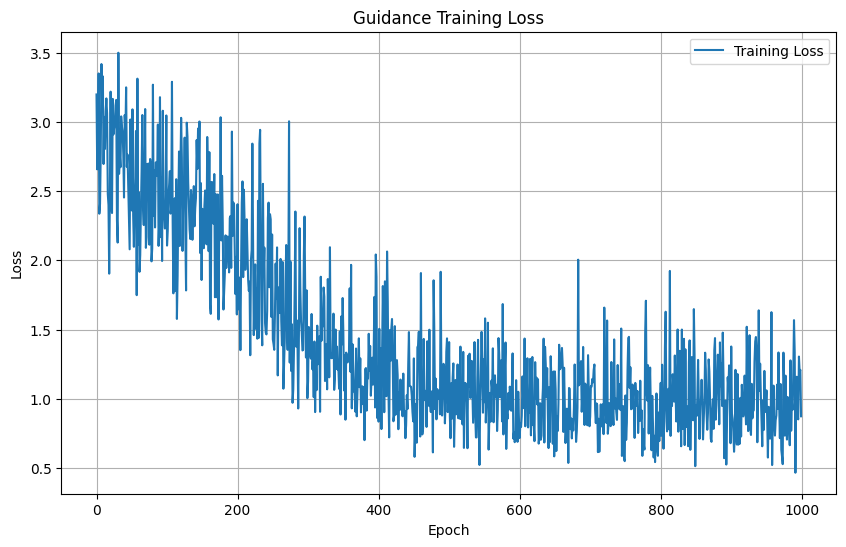

Training loss plot generated successfully.


In [42]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Guidance Training Loss')
plt.grid(True)
plt.legend()
plt.show()

print("Training loss plot generated successfully.")

## Visualize trajectory path

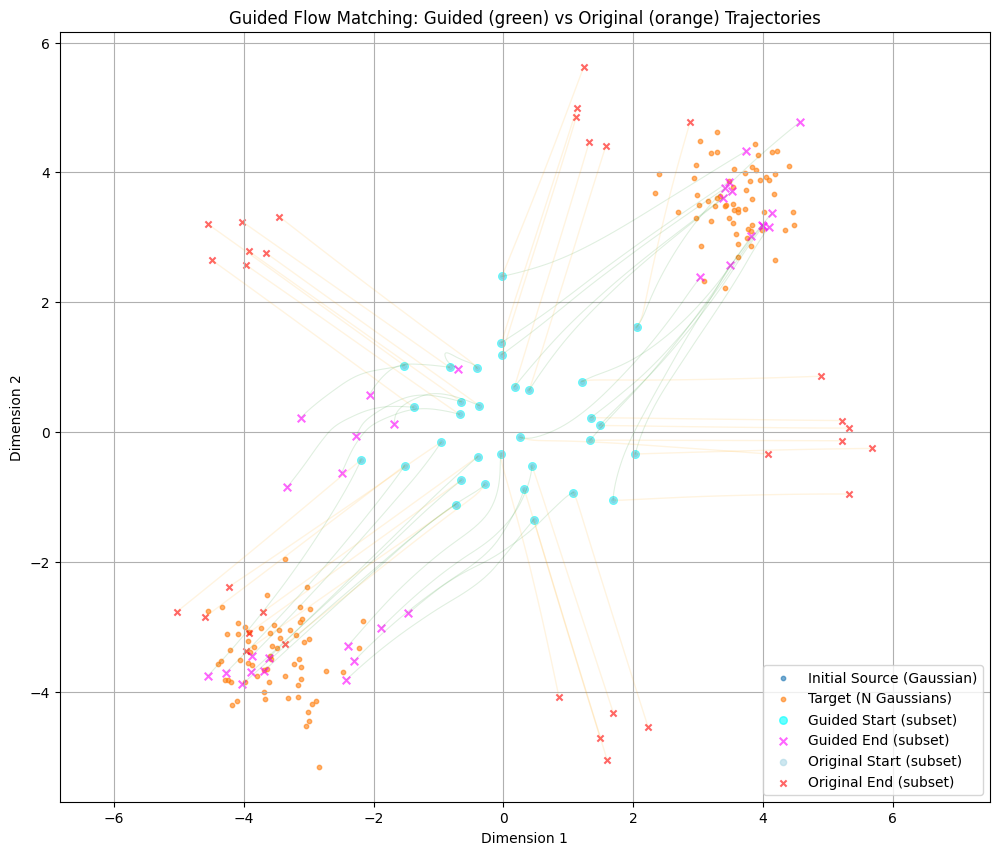

Trajectory visualization (guided + original) generated successfully.


In [44]:
# --- (assumes imports, device, model, guided_vector, sample_gaussian, guided_data, plt are already defined) ---

guided_vector.eval()
model.eval()

# Number of trajectories to simulate
num_trajectory_samples = 32

# Sample initial points from the source Gaussian distribution
x0_eval = sample_gaussian(num_trajectory_samples).to(device)

# Sample target points from the 2 Gaussians distribution (for context)
x1_eval_context = guided_data.to(device)

# Simulation parameters
t_steps = 50  # Number of time steps for trajectory simulation
delta_t = 1.0 / t_steps

# Prepare tensors to store trajectories for both guided and original models
trajectories_guided = torch.zeros(t_steps + 1, num_trajectory_samples, 2, device=device)
trajectories_orig   = torch.zeros(t_steps + 1, num_trajectory_samples, 2, device=device)

trajectories_guided[0] = x0_eval
trajectories_orig[0] = x0_eval

current_x_g = x0_eval.clone()
current_x_o = x0_eval.clone()

with torch.no_grad():  # No gradients needed for simulation
    for i in range(t_steps):
        t_val = torch.full((num_trajectory_samples, 1), i * delta_t, device=device)

        # velocities
        vel_g = model(current_x_g, t_val) + guided_vector(current_x_g, t_val)  # guided
        vel_o = model(current_x_o, t_val)                                      # original

        # Euler integration step
        current_x_g = current_x_g + vel_g * delta_t
        current_x_o = current_x_o + vel_o * delta_t

        # save
        trajectories_guided[i+1] = current_x_g
        trajectories_orig[i+1] = current_x_o

# Move to CPU for plotting
tra_g_cpu = trajectories_guided.cpu().numpy()
tra_o_cpu = trajectories_orig.cpu().numpy()
x0_eval_cpu = x0_eval.cpu().numpy()
x1_eval_context_cpu = x1_eval_context.cpu().numpy()

# Plotting
plt.figure(figsize=(12, 10))
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# Plot initial source distribution
plt.scatter(x0_eval_cpu[:, 0], x0_eval_cpu[:, 1], label='Initial Source (Gaussian)', s=10, alpha=0.6)

# Plot final target distribution (context)
plt.scatter(x1_eval_context_cpu[:, 0], x1_eval_context_cpu[:, 1], label='Target (N Gaussians)', s=10, alpha=0.6)

# To keep the figure readable, only plot a subset of trajectories (adjust max_plotted as desired)
max_plotted = 256
idxs = np.linspace(0, num_trajectory_samples - 1, min(max_plotted, num_trajectory_samples), dtype=int)

# Plot guided trajectories (thinner, green)
for i in idxs:
    plt.plot(tra_g_cpu[:, i, 0], tra_g_cpu[:, i, 1], color='green', alpha=0.12, linewidth=0.8)

# Plot original model trajectories (thicker, orange) for easier visual comparison
for i in idxs:
    plt.plot(tra_o_cpu[:, i, 0], tra_o_cpu[:, i, 1], color='orange', alpha=0.12, linewidth=1.0)

# Distinct start/end markers (guided vs original)
plt.scatter(tra_g_cpu[0, idxs, 0], tra_g_cpu[0, idxs, 1], color='cyan', marker='o', s=30, alpha=0.6, label='Guided Start (subset)')
plt.scatter(tra_g_cpu[-1, idxs, 0], tra_g_cpu[-1, idxs, 1], color='magenta', marker='x', s=30, alpha=0.6, label='Guided End (subset)')

plt.scatter(tra_o_cpu[0, idxs, 0], tra_o_cpu[0, idxs, 1], color='lightblue', marker='o', s=20, alpha=0.6, label='Original Start (subset)')
plt.scatter(tra_o_cpu[-1, idxs, 0], tra_o_cpu[-1, idxs, 1], color='red', marker='x', s=20, alpha=0.6, label='Original End (subset)')

plt.title('Guided Flow Matching: Guided (green) vs Original (orange) Trajectories')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='lower right')
plt.grid(True)
plt.axis('equal')  # Keep aspect ratio equal
plt.show()

print("Trajectory visualization (guided + original) generated successfully.")


# **Model Evaluation**

In [45]:
train_data = guided_data
train_dataset = torch.utils.data.TensorDataset(train_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
train_guidance_losses = []
train_robustness_losses = []

epochs = 1000

for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        x0_test = sample_gaussian(data[0].shape[0]).to(device)
        x1_test = data[0].to(device)

        train_guide_loss = guidance_loss(guided_vector, model, x0_test, x1_test, device)
        train_robust_loss = consistency_loss(guided_vector, model, x0_test, x1_test, device)

        train_guidance_losses.append(train_guide_loss.item())
        train_robustness_losses.append(train_robust_loss.item())

print(f"Train guidance loss: {np.mean(np.array(train_guidance_losses))}")
print(f"Train robustness loss: {np.mean(np.array(train_robustness_losses))}")

Train guidance loss: 4.683869862556458
Train robustness loss: 2.0165541269779204


In [46]:
test_data = sample_n_gaussians(50000, num_gaussians=2, rotation=1*np.pi/4)
test_dataset = torch.utils.data.TensorDataset(test_data)
guidance_losses = []
robustness_losses = []

for i, data in enumerate(torch.utils.data.DataLoader(test_dataset, batch_size=256)):
    x0_test = sample_gaussian(data[0].shape[0]).to(device)
    x1_test = data[0].to(device)

    guide_loss = guidance_loss(guided_vector, model, x0_test, x1_test, device)
    robust_loss = consistency_loss(guided_vector, model, x0_test, x1_test, device)

    guidance_losses.append(guide_loss.item())
    robustness_losses.append(robust_loss.item())

print(f"Test guidance loss: {np.mean(np.array(guidance_losses))}")
print(f"Test robustness loss: {np.mean(np.array(robustness_losses))}")

Test guidance loss: 4.701023162627707
Test robustness loss: 2.088030221510907
